# Upper Upper Green PEST Pilot Point Setup

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import flopy as flopy
import pyemu
import shapefile #the pyshp module
from pyemu.pst.pst_utils import SFMT,IFMT,FFMT,pst_config
import matplotlib.pyplot as plt


In [2]:
# from apexmf import apexmf_pst_utils

In [3]:

sys.path.insert(1, 'd:/spark-brc_gits/apexmf_git/')
from apexmf import apexmf_pst_par, apexmf_utils
from apexmf import apexmf_pst_utils

In [4]:
wd = "d:/Projects/Watersheds/Green/Analysis/AMRSs/salt_cal_230117/gr_012721/APEX-MODFLOW/"
mfd = os.path.join(wd, "MODFLOW")
# pstfile = "dolores_amrs.pst"
os.chdir(wd)

# MODFLOW parameters with Pilot Points

In [7]:
# m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=wd,load_only=[]) #<-- load only prevents reading ibound
mname = 'gr_1000.nam'
m = flopy.modflow.Modflow.load(mname,
            model_ws=wd
            )
m.check()

Errors and/or Warnings encountered.
Errors and/or Warnings encountered.

gr_1000 MODEL DATA VALIDATION SUMMARY:
  16 Errors:
    DIS package: thin cells (less than checker threshold of 1.0)
    UPW package: zero or negative horizontal hydraulic conductivity values
  34 Warnings:
    OC package: action(s) defined in OC stress_period_data ignored as they are not part the stress periods defined by DIS
    RCH package: Mean R/T ratio < checker warning threshold of 2e-08 for 1 stress periods
    RCH package: Variable NRCHOP set to value other than 3
    RIV package: BC in inactive cell
    UPW package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    UPW package: vertical hydraulic conductivity values below checker threshold of 1e-11

  Checks that passed:
    Unit number conflicts
    Compatible solver package
    DIS package: zero or negative thickness
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolat

In [8]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(wd, mname),
        delr=m.dis.delr.array, delc=m.dis.delc.array)

   could not remove start_datetime


In [ ]:
# Create pilot points as a shapefile
# we want hk pilot points in the top layer...
prefix_dict = {0:["sy0"]}
df_pp_hk = pyemu.pp_utils.setup_pilotpoints_grid(ml=m,
                                              prefix_dict=prefix_dict,
                                              pp_dir=wd,
                                              tpl_dir=wd,
                                              every_n_cell=10,
                                              shapename='pp_sy.shp')

In [10]:
# change shapefile and file name
shpwd = wd
shp = 'pp_sy.shp'
shp_changed = 'sy0pp.shp'
ppf = shp_changed[:-3] + 'dat'
ppf

'sy0pp.dat'

In [13]:
shpwd = os.path.join(wd, "MODFLOW")

In [14]:
shapefile_path

'd:/Projects/Watersheds/Green/Analysis/AMRSs/salt_cal_230117/gr_012721/APEX-MODFLOW/pp_sy.shp'

In [15]:
#read file, parse out the records and shapes
shapefile_path = os.path.join(shpwd, shp)
sf = shapefile.Reader(shapefile_path)

#grab the shapefile's field names (omit the first psuedo field)
fields = [x[0] for x in sf.fields][1:]
records = sf.records()
shps = [s.points for s in sf.shapes()]

#write the records into a dataframe
shapefile_dataframe = pd.DataFrame(columns=fields, data=records)

#add the coordinate data to a column called "coords"
shapefile_dataframe = shapefile_dataframe.assign(coords=shps)

pp_df = shapefile_dataframe.sort_values(by=['name'])
print(pp_df)

        name         x         y  zone  parval1  k    i    j   
0    pp_0000   68250.0  269250.0   1.0      1.0  0    5   45  \
1    pp_0001   68250.0  254250.0   1.0      1.0  0   15   45   
2    pp_0002   83250.0  254250.0   1.0      1.0  0   15   55   
3    pp_0003   53250.0  239250.0   1.0      1.0  0   25   35   
4    pp_0004   68250.0  239250.0   1.0      1.0  0   25   45   
..       ...       ...       ...   ...      ... ..  ...  ...   
105  pp_0105  143250.0   29250.0   1.0      1.0  0  165   95   
106  pp_0106  158250.0   29250.0   1.0      1.0  0  165  105   
107  pp_0107  113250.0   14250.0   1.0      1.0  0  175   75   
108  pp_0108  128250.0   14250.0   1.0      1.0  0  175   85   
109  pp_0109  143250.0   14250.0   1.0      1.0  0  175   95   

                  tpl  parnme  ...   
0    ~    sy0000    ~  sy0000  ...  \
1    ~    sy0001    ~  sy0001  ...   
2    ~    sy0002    ~  sy0002  ...   
3    ~    sy0003    ~  sy0003  ...   
4    ~    sy0004    ~  sy0004  ...   
.. 

- get list of salt ion
- change tpl name for new par name
- write dataframe to pp.dat file
- write tpl file for pp.dat file


In [16]:
sions_ = ["SO4", "Ca", "Mg", "Na", "K", "Cl"]
sions = [i.lower() for i in sions_] 
sions

['so4', 'ca', 'mg', 'na', 'k', 'cl']

In [17]:
sionsf = [f"salt_{i.lower()}0pp.dat.ref" for i in sions_] 

In [18]:
sionsf

['salt_so40pp.dat.ref',
 'salt_ca0pp.dat.ref',
 'salt_mg0pp.dat.ref',
 'salt_na0pp.dat.ref',
 'salt_k0pp.dat.ref',
 'salt_cl0pp.dat.ref']

In [19]:
conts = [200000, 4500, 900, 4.5e+007, 10, 2e+007]
rgs = [9900, 23400, 13500, 21600, 9900, 21600]


In [23]:
for ionnam, cont, rg in zip(sions, conts, rgs):
    df = pp_df.copy()
    # write dataframe to pp.dat file
    new_df = change_tpl_name(df, f"salt_{ionnam}", oldnam='sy')
    pyemu.utils.pp_utils.write_pp_file(f"salt_{ionnam}0pp.dat", new_df) # create dat
    pp_to_tpl(new_df, f"salt_{ionnam}0pp.dat") # create tpl
    intp_krigging(cont, rg, new_df, ionnam)

starting interp point loop for 21645 points
took 79.230244 seconds
starting interp point loop for 21645 points
took 81.345254 seconds
starting interp point loop for 21645 points
took 76.887996 seconds
starting interp point loop for 21645 points
took 82.106342 seconds
starting interp point loop for 21645 points
took 81.659766 seconds
starting interp point loop for 21645 points
took 82.854612 seconds


In [24]:
os.getcwd()

'd:\\Projects\\Watersheds\\Green\\Analysis\\AMRSs\\salt_cal_230117\\gr_012721\\APEX-MODFLOW'

In [20]:
def change_tpl_name(tpl_df, newnam, oldnam='sy'):
    tpl_df['tpl'] = tpl_df['tpl'].str.replace(oldnam, newnam)
    tpl_df['pargp'] = tpl_df['pargp'].str.replace(oldnam, newnam)
    tpl_df['parnme'] = tpl_df['parnme'].str.replace(oldnam, newnam)
    return tpl_df

In [21]:
PP_FMT = {"name": SFMT, "x": FFMT, "y": FFMT, "zone": IFMT, "tpl": SFMT,
          "parval1": FFMT}
def pp_to_tpl(new_df, pp_file, tpl_file=None):
    names = new_df['parnme'].tolist() # for hk
    # names = new_df['sypar'].tolist() # for sy  
#     names = new_df['parnme'].tolist() # for river conductance      
    if tpl_file is None:
        tpl_file = pp_file + ".tpl"    
    tpl_entries = ["~    {0}    ~".format(name) for name in names]
    new_df.loc[:,"tpl"] = tpl_entries
    new_df.loc[:,"parnme"] = names


    f_tpl = open(tpl_file,'w')
    f_tpl.write("ptf ~\n")
    f_tpl.write(new_df.to_string(col_space=0,
                              columns=["name","x","y","zone","tpl"],
                              formatters=PP_FMT,
                              justify="left",
                              header=False,
                              index=False) + '\n')    


In [22]:
def intp_krigging(cont, a, new_df, ionnam):
    v = pyemu.geostats.ExpVario(contribution=cont,a=a, bearing=0)
    gs = pyemu.geostats.GeoStruct(variograms=v,nugget=0)
    ok = pyemu.geostats.OrdinaryKrige(gs,new_df)
    df = ok.calc_factors_grid(sr,
    #                           var_filename=pst_name.replace(".pst",".var.ref"),
                              var_filename= f"salt_{ionnam}0pp." + "var.ref",                          
                              minpts_interp=1,maxpts_interp=50,
                              search_radius=5000000000000.0)
    ok.to_grid_factors_file(f"salt_{ionnam}0pp.dat"+".fac")

In [25]:
ionnam = "so4"

In [26]:
df = pp_df.copy()
# write dataframe to pp.dat file
new_df = change_tpl_name(df, f"salt_{ionnam}", oldnam='sy')

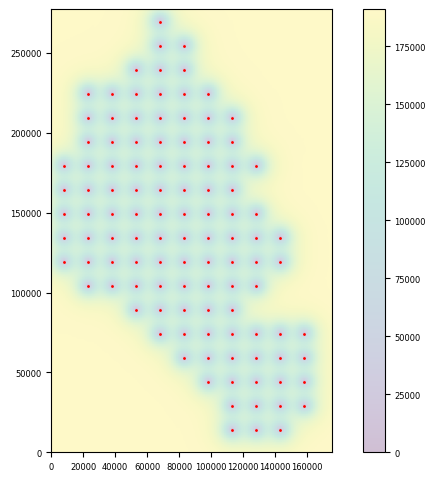

In [27]:
# arr_var = np.loadtxt(pst_name.replace(".pst",".var.ref"))
arr_var = np.loadtxt(f"salt_{ionnam}0pp." + "var.ref")
ax = plt.subplot(111,aspect="equal")
p = ax.imshow(arr_var,extent=sr.get_extent(),alpha=0.25)
plt.colorbar(p)
plt.tight_layout()
ax.scatter(pp_df.x,pp_df.y,marker='.',s=4,color='r')

In [31]:
# generate random values
new_df.loc[:,"parval1"] = np.random.random(new_df.shape[0])
# save a pilot points file
pyemu.pp_utils.write_pp_file(f"salt_{ionnam}0pp.dat",new_df)

In [32]:
# interpolate the pilot point values to the grid
hk_arr = pyemu.utils.geostats.fac2real(f"salt_{ionnam}0pp.dat",factors_file=f"salt_{ionnam}0pp.dat"+".fac",out_file=None)

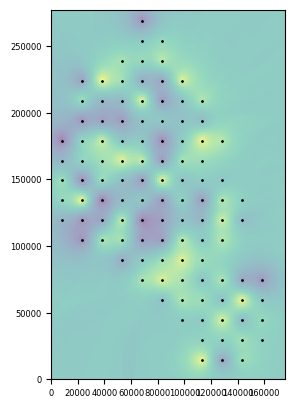

In [33]:
# plot
ax = plt.subplot(111,aspect='equal')
ax.imshow(hk_arr,interpolation="nearest",extent=sr.get_extent(),alpha=0.5)
ax.scatter(new_df.x,new_df.y,marker='.',s=4,color='k')

# Create instruction file for observed depth to water

In [2]:
wd = "D:/Projects/Watersheds/Animas/Analysis/APEX-MODFLOWs/calibrations/v03"
os.chdir(wd)

In [3]:
mf_obs = pd.read_csv(
                    "MODFLOW/modflow.obs",
                    delim_whitespace=True,
                    skiprows = 2,
                    usecols = [3, 4],
                    index_col = 0,
                    names = ["grid_id", "mf_elev"],)
grid_ids = mf_obs.index.tolist()

In [4]:
grid_ids = [5895, 6273]

In [5]:
apexmf_pst_utils.extract_depth_to_water(grid_ids, '1/1/1987', '10/30/2003')

dtw_5895.txt file has been created...
dtw_6273.txt file has been created...
Finished ...


In [35]:
mfobd_file = 'dtw_day.obd'

In [36]:
mfobd_df = pd.read_csv(
                    "MODFLOW/" + mfobd_file,
                    sep='\s+',
                    index_col=0,
                    header=0,
                    parse_dates=True,
                    na_values=[-999, ""],
                    delimiter="\t")

In [39]:
# Change depth to water to absolute values
absmfobd_df = mfobd_df.abs()
absmfobd_df.to_csv('dtw_day.obd', sep='\t', na_rep=-999, float_format='%.2f')


In [7]:
apexmf_pst_utils.mf_obd_to_ins('dtw_6273.txt', 'gw_098', '1/1/1987', '10/30/2003')

dtw_6273.txt.ins file has been created...


In [4]:
os.getcwd()

'D:\\Projects\\Watersheds\\Animas\\Analysis\\APEX-MODFLOWs\\calibrations\\v03'

In [68]:
pst.control_data.noptmax=0
pst.model_command = 'python forward_run.py'
pst.model_input_data = apexmf_pst_utils.modify_mf_tpl_path(pst.model_input_data)
pst.write('animas_pest.pst')

noptmax:0, npar_adj:100, nnz_obs:1745
